## Load Required Library

In [2]:
# Create connection to the staging directory.
import boto3
import sagemaker
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
try:
    from pyathena import connect
except:
    !pip install --disable-pip-version-check -q PyAthena==2.1.0
    from pyathena import connect

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

bucket = 'ads508team7'
raw_file_dir   = f"s3://{bucket}/raw_files"
s3_staging_dir = f"s3://{bucket}/athena/staging"
database_name  = 'sys'
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Get Proportation of Re-ordered Items Per Department

In [3]:
query = """
SELECT 
sys.Departments.department as department, 
COUNT(sys.Products.product_name) AS qty_sold, 
sys.Order_products__train.reordered as reordered

FROM sys.Order_products__train 
INNER JOIN sys.Products 
    ON sys.Order_products__train.product_id = sys.Products.product_id
INNER JOIN sys.Departments 
    ON sys.Products.department_id = sys.Departments.department_id

GROUP BY department, reordered
ORDER BY qty_sold DESC
"""

product_sold_reorder = pd.read_sql(query, conn)

In [4]:
# add a dataframe to have perportion of reordered items for each department

def get_dept_sold(dept): 
    info = {}
    applicable_rows = product_sold_reorder.query('department == @dept')
    total_sold = applicable_rows.qty_sold.sum()
    
    info['dept'] = dept
    info['total_sold'] = total_sold
    
    info['reordered'] = applicable_rows.query('reordered == 1').qty_sold.sum()
    info['not_reordered'] = applicable_rows.query('reordered == 0').qty_sold.sum()
    
    info['reordered_perc'] = float('{:.1f}'.format(info['reordered'] / total_sold * 100))
    info['not_reordered_perc'] = float('{:.1f}'.format(info['not_reordered'] / total_sold * 100))
    return info

proportion_dict = {}
for dept in product_sold_reorder.department.unique():
    proportion_dict[dept] = get_dept_sold(dept)
                                               
df_proportion = pd.DataFrame.from_dict(proportion_dict, orient = 'index').drop(['dept'], axis = 1)  

proportion_cols = ['total_sold','reordered_perc','not_reordered_perc']
df_proportion[proportion_cols]

,total_sold,reordered_perc,not_reordered_perc
produce,402665,66.6,33.4
dairy eggs,211919,67.4,32.6
beverages,110925,65.8,34.2
snacks,114523,58.0,42.0
frozen,97507,56.0,44.0
pantry,79052,36.4,63.6
bakery,46959,63.4,36.6
deli,42958,61.9,38.1
canned goods,45465,48.8,51.2
dry goods pasta,37849,48.7,51.3


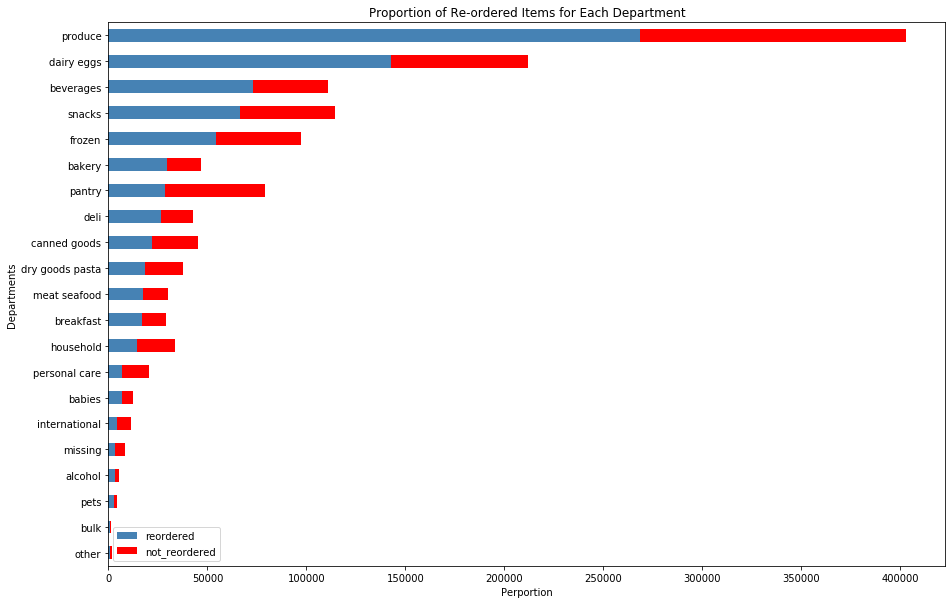

In [5]:
data_to_plot = df_proportion[['reordered','not_reordered']].sort_values(by=["reordered"]) 

data_to_plot.plot(kind='barh', stacked=True, color=['steelblue', 'red'], figsize=(15, 10), legend= 6)

plt.ylabel('Departments')
plt.xlabel('Perportion')
plt.title('Proportion of Re-ordered Items for Each Department')
plt.show()

## Balance the Dataset by Department and Re-order Classification

In [114]:
try:
    from jinja2 import Template
except:    
    !pip install jinja
    import jinja

query_string = f"""
SELECT 
    sys.Order_products__train.*,
    sys.Departments.department AS department

FROM sys.Order_products__train 

INNER JOIN sys.Products 
    ON sys.Order_products__train.product_id = sys.Products.product_id
INNER JOIN sys.Departments 
    ON sys.Products.department_id = sys.Departments.department_id

WHERE 
    department = '{{{{department_name}}}}' AND
    sys.Order_products__train.reordered = {{{{reorder_type}}}}
"""

least_records = min(df_proportion.reordered.min(), df_proportion.not_reordered.min())    

print(f'{least_records} records will randomly be picked from each department for both of reordered classification (0 and 1)')
print(f'--------------------------------------------------------------------------------------------------------\n')
print('Below is the query that will be used to get each department and reordered type:')

query_sample = Template(query_string).render(department_name = 'sample department name', reorder_type = 0)
print(query_sample)

599 records will randomly be picked from each department for both of reordered classification (0 and 1)
--------------------------------------------------------------------------------------------------------

Below is the query that will be used to get each department and reordered type:

SELECT 
    sys.Order_products__train.*,
    sys.Departments.department AS department

FROM sys.Order_products__train 

INNER JOIN sys.Products 
    ON sys.Order_products__train.product_id = sys.Products.product_id
INNER JOIN sys.Departments 
    ON sys.Products.department_id = sys.Departments.department_id

WHERE 
    department = 'sample department name' AND
    sys.Order_products__train.reordered = 0


In [113]:
department_list = df_proportion.index.tolist()

df_balanced = pd.DataFrame()
for departmnet in department_list:
    for classification in [0,1]:
        query_to_run = Template(query_string).render(department_name = departmnet, reorder_type = classification)
        
        df_dept_class = pd.read_sql(query_to_run, conn).sample(least_records)
        df_balanced = pd.concat([df_balanced, df_dept_class])
        print(f"Departmnet '{departmnet}' with reordered as '{classification}' was added to balanced dataframe.")

print(df_balanced.shape)
df_balanced

Departmnet 'produce' with reordered as '0' was added to balanced dataframe.
Departmnet 'produce' with reordered as '1' was added to balanced dataframe.
Departmnet 'dairy eggs' with reordered as '0' was added to balanced dataframe.
Departmnet 'dairy eggs' with reordered as '1' was added to balanced dataframe.
Departmnet 'beverages' with reordered as '0' was added to balanced dataframe.
Departmnet 'beverages' with reordered as '1' was added to balanced dataframe.
Departmnet 'snacks' with reordered as '0' was added to balanced dataframe.
Departmnet 'snacks' with reordered as '1' was added to balanced dataframe.
Departmnet 'frozen' with reordered as '0' was added to balanced dataframe.
Departmnet 'frozen' with reordered as '1' was added to balanced dataframe.
Departmnet 'pantry' with reordered as '0' was added to balanced dataframe.
Departmnet 'pantry' with reordered as '1' was added to balanced dataframe.
Departmnet 'bakery' with reordered as '0' was added to balanced dataframe.
Departmne

,order_id,product_id,add_to_cart_order,reordered,department
29460,696377,26209,39,0,produce
68399,1710992,11943,8,0,produce
115433,2937357,21903,3,0,produce
90043,1925852,4605,6,0,produce
14515,44018,21385,1,0,produce
...,...,...,...,...,...
102,549494,7314,9,1,bulk
656,3024953,22260,9,1,bulk
342,1453497,5161,5,1,bulk
21,240974,43210,15,1,bulk


In [121]:
# save balanced data frame in s3 to be used for future notebooks

from io import StringIO
try:
    import awswrangler as wr
except:
    !pip install awswrangler
    import awswrangler as wr
    
bucket = 'ads508team7'
save_to_path = f'balanced/train_balanced.csv'
csv_buffer = StringIO()
df_balanced.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, save_to_path).put(Body=csv_buffer.getvalue())

# verify if it was saved successfully
verification = wr.s3.read_csv(path=f's3://{bucket}/{save_to_path}')
verification.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,department
0,29460,696377,26209,39,0,produce
1,68399,1710992,11943,8,0,produce
2,115433,2937357,21903,3,0,produce
3,90043,1925852,4605,6,0,produce
4,14515,44018,21385,1,0,produce
